In [13]:
import tensorflow as tf 
from tensorflow.python.framework import graph_util # used for exporting the graph

# Importing the MNIST data set.
from tensorflow.examples.tutorials.mnist import input_data

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn as sk
import sklearn.metrics

MODEL_SAVE_PATH = "./"
# Please fill in your attendee number for identification of your model later on
ATTENDEE_ID = None

tf.__version__

'1.3.0'

## GPU and CPU settings
If GPU is not available, comment out the bottom block.

In [2]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
GPU_USE = '/gpu:0'
config = tf.ConfigProto()
config.log_device_placement=True
config.allow_soft_placement=True
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction=0.1
config.gpu_options.allocator_type = 'BFC'

## Loading MNIST Data set

In [3]:
mnist = input_data.read_data_sets("mnist_data/", one_hot=True) # tf.estimator handles classes itself

train_x = mnist.train.images
train_y = mnist.train.labels

test_x = mnist.test.images
test_y = mnist.test.labels

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


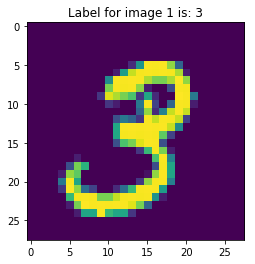

In [4]:
# Plotting an example image
i = 1
plt.imshow(mnist.train.images[i].reshape(28,28)) #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, np.argmax(mnist.train.labels[i])))

## Training parameters

In [5]:
# Number of classes
n_classes = len(mnist.train.labels[0]) # equals 10 as we have 10 numbers to classify.

# Number of features as input for the neural network
n_features = len(mnist.train.images[0]) # equals to 768 (28 x 28 image)

# Input and output node names
input_tensor = "input" 
output_tensor = "output"

## Hyperparameters

In [6]:
tf.reset_default_graph()

# Number of neurons per layer
n_hidden_1 = 10 

# Training settings
learning_rate = 0.1
batch_size = 100
training_epochs = 20

## Network definition

In [7]:
# Variable definition
_x = tf.placeholder(tf.float32, [None, n_features], name=input_tensor)
_y = tf.placeholder(tf.float32, [None, n_classes], name="y")

rg_weights = {
    'h1': tf.Variable(tf.random_normal([n_features, n_hidden_1])),
    'hOut': tf.Variable(tf.random_normal([n_hidden_1, n_classes]))
}

rg_biases =  {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'bOut': tf.Variable(tf.random_normal([n_classes]))
}

    
def reg_perceptron(t, weights, biases):
    t = tf.nn.relu(tf.add(tf.matmul(t, weights['h1']), biases['b1']), name = "layer_1")
    t = tf.add(tf.matmul(t, weights['hOut'], name="LOut_MatMul"), biases['bOut'], name = output_tensor)
    return t
    
pred = reg_perceptron(_x, rg_weights, rg_biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=_y))

## Optimizer selection

In [8]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
# Toggle comments to try out different optimizers
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
# optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(cost)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
# optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate).minimize(cost)
# optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate).minimize(cost)
# optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate).minimize(cost)
# optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate).minimize(cost)

## Initialization of network

In [9]:
# Definition of TF operations
init_op = tf.global_variables_initializer()
saver = tf.train.Saver()

## Train the neural network

In [10]:
save_path = MODEL_SAVE_PATH + "mnist_model/"

with tf.device(GPU_USE):
    with tf.Session(config=config) as sess:
        sess.run(init_op)

        for epoch in range(training_epochs):
            total_batch = int(len(train_x)/batch_size)
            
            
            # Loop over all batches for training
            for i in range(total_batch):
                lower_bound = i * batch_size
                upper_bound = i * batch_size + batch_size
                batch_x = train_x[lower_bound : upper_bound]
                batch_y = train_y[lower_bound : upper_bound]

                # Run optimization operation and calculate cost
                feed_dict = {_x: batch_x, _y: batch_y}
                _, c = sess.run([optimizer, cost], feed_dict = feed_dict)
                
            
            # Print test results.
            correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(_y, 1))
            acc_op = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            accuracy = acc_op.eval({_x: test_x, _y: test_y})

            y_pred = tf.argmax(pred, 1).eval({_x: test_x, _y: test_y})
            y_true = np.argmax(test_y,1)
            precision = sk.metrics.precision_score(y_true, y_pred, average="micro")
            recall = sk.metrics.recall_score(y_true, y_pred, average="micro")
            print ("Epoch: %3.i - Acc: %.2f, Prec: %.2f,  Rec: %.2f " % (epoch, accuracy, precision, recall))

#             op_assign_cost = _cost.assign(avg_cost)
#             op_assign_acc = _accuracy.assign(accuracy)
#             _, _ = sess.run([op_assign_cost, op_assign_acc]) 

#             feed_dict = {_x: test_x, _y: test_y}
#             summary = sess.run(merged_summary, feed_dict=feed_dict)
#             train_writer.add_summary(summary,  _epoch_count.eval())

            saver.save(sess, save_path + "model", global_step=epoch, write_meta_graph=True)
            
        print("Optimization Finished!")

        # Test model
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(_y, 1))
        acc_op = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        accuracy = acc_op.eval({_x: test_x, _y: test_y})

        y_pred = tf.argmax(pred, 1).eval({_x: test_x, _y: test_y})
        y_true = np.argmax(test_y,1)
        precision = sk.metrics.precision_score(y_true, y_pred, average="micro")
        recall = sk.metrics.recall_score(y_true, y_pred, average="micro")
        print ("Final test results: Acc: %.2f, Prec: %.2f,  Rec: %.2f " % (accuracy, precision, recall))
        
        print (sk.metrics.confusion_matrix(y_true, y_pred))
        
        print("Model save path:", save_path)
        

Epoch:   0 - Acc: 0.36, Prec: 0.36,  Rec: 0.36 
Epoch:   1 - Acc: 0.53, Prec: 0.53,  Rec: 0.53 
Epoch:   2 - Acc: 0.63, Prec: 0.63,  Rec: 0.63 
Epoch:   3 - Acc: 0.68, Prec: 0.68,  Rec: 0.68 
Epoch:   4 - Acc: 0.73, Prec: 0.73,  Rec: 0.73 
Epoch:   5 - Acc: 0.76, Prec: 0.76,  Rec: 0.76 
Epoch:   6 - Acc: 0.78, Prec: 0.78,  Rec: 0.78 
Epoch:   7 - Acc: 0.80, Prec: 0.80,  Rec: 0.80 
Epoch:   8 - Acc: 0.81, Prec: 0.81,  Rec: 0.81 
Epoch:   9 - Acc: 0.82, Prec: 0.82,  Rec: 0.82 
Epoch:  10 - Acc: 0.83, Prec: 0.83,  Rec: 0.83 
Epoch:  11 - Acc: 0.83, Prec: 0.83,  Rec: 0.83 
Epoch:  12 - Acc: 0.84, Prec: 0.84,  Rec: 0.84 
Epoch:  13 - Acc: 0.84, Prec: 0.84,  Rec: 0.84 
Epoch:  14 - Acc: 0.84, Prec: 0.84,  Rec: 0.84 
Epoch:  15 - Acc: 0.85, Prec: 0.85,  Rec: 0.85 
Epoch:  16 - Acc: 0.85, Prec: 0.85,  Rec: 0.85 
Epoch:  17 - Acc: 0.86, Prec: 0.86,  Rec: 0.86 
Epoch:  18 - Acc: 0.86, Prec: 0.86,  Rec: 0.86 
Epoch:  19 - Acc: 0.87, Prec: 0.87,  Rec: 0.87 
Optimization Finished!
Final test result

## Loading and exporting model

In [14]:


def freeze_graph(model_folder, model_file_name = None):
    GPU_USE = '/cpu:0'
    config = tf.ConfigProto(device_count = {"GPU": 0})
    
    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state(model_folder)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_folder = "/".join(input_checkpoint.split('/')[:-1])
    print (absolute_model_folder)
    if (model_file_name == None):
        model_file_name = input_checkpoint.split("/")[-1].split(".")[0]
    else:
        input_checkpoint = absolute_model_folder + "/" + model_file_name
    print (model_file_name)
    if ATTENDEE_ID == None:
        print ("ERROR: Please set ATTENDEE_ID first")
        return
    
    # If you use our Script outside of the tutorial please specify your path to store the model
    output_graph = "/var/www/html/tutorial-data/model-" + str(ATTENDEE_ID) + ".pb"

    # Output node for TensorFlow to decide which part of the Graph to keep.

    print("Saver is loading: " + input_checkpoint + '.meta')
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=True)

    # We retrieve the protobuf graph definition
    graph = tf.get_default_graph()
    input_graph_def = graph.as_graph_def()

    # start session and write the exported file. 
    with tf.device(GPU_USE):
        with tf.Session() as sess:
            saver.restore(sess, input_checkpoint)

            output_graph_def = graph_util.convert_variables_to_constants(
                sess, # The session is used to retrieve the weights
                input_graph_def, # The graph_def is used to retrieve the nodes 
                [output_tensor] # The output node names are used to select the useful nodes.
            ) 

            # Serialize and dump the output graph to the filesystem
            with tf.gfile.GFile(output_graph, "wb") as f:
                f.write(output_graph_def.SerializeToString())
            print("%d ops in the final graph." % len(output_graph_def.node))
            print("Wrote model to %s" % output_graph)

In [15]:
freeze_graph(save_path)

./mnist_model
model-19
Saver is loading: ./mnist_model/model-19.meta
INFO:tensorflow:Restoring parameters from ./mnist_model/model-19
INFO:tensorflow:Froze 4 variables.
Converted 4 variables to const ops.
14 ops in the final graph.
Wrote model to /var/www/html/tutorial-data/model-1.pb
